# HK PROTESTS: Visualising Chinese State Troll Tweets, Part 1

This is the second part of my analysis of the trove of Chinese state troll tweets aimed at the Hong Kong protests. [Twitter released the dataset on Aug 19](https://blog.twitter.com/en_us/topics/company/2019/information_operations_directed_at_Hong_Kong.html) and you can download the set from the link if you wish to re-run this notebook on your local machine. The CSV files are unfortunately too big to be uploaded on Github.

In this section, I'll focus on using some basic NLP tools as well as the Scattertext library to visualise key terms in the Chinese state troll tweets. To prevent the notebooks from becoming too bloated and computationally expensive to run, I've split them up according to the language and tools used:

- notebook 2.0: "De-layering" and visulisation of English tweets by Chinese state trolls
- notebook 2.1: Scattertext plot of English tweets by Chinese state trolls
- notebook 2.2: "De-layering" and visulisation of Chinese language tweets by Chinese state trolls
- notebook 2.3: Scattertext plot of English tweets by Chinese state trolls

My initial EDA is in [notebook 1.0](https://github.com/chuachinhon/twitter_hk_trolls_cch/blob/master/notebooks/1.0_HK_EDA_cch.ipynb)


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import squarify

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# 1. "DE-LAYERING" THE ENGLISH TROLL TWEETS

This particular set of troll tweets released by Twitter has over 3.6 million rows, and tweets in 59 languages. And it is extremely noisy - cluttered with sports and porn-related tweets, and a running war of words between the trolls and fugitive Chinese billionaire [Guo Wengui](https://en.wikipedia.org/wiki/Guo_Wengui).

Adding to the noise, the state trolls accounts, now suspended, were tweeting in multiple languages. Example, a troll which had set the account language setting to English could tweet in both English and Chinese, or more languages.

Many of the accounts also had been dormant for a long time, as [this analysis] shows(https://twitter.com/AirMovingDevice/status/1163997735638319106).

To contain the complexity of the analysis, I took the following steps:
- Focus only on English and Chinese tweets (since the primary audiences are Hong Kongers), but making sure that I capture the English tweets from accounts with Chinese language settings, and vice versa.  

- Set 2017 as the start point for analysis, seeing that many regard the Russian 2016 disinformation campaign in the US as having inspired significant tactical changes in recent state disinformation efforts. The Chinese trolls have, of course, been active on Twitter far earlier than 2017.

- Use obvious key terms, such as "Hong Kong" and "police", as anchor points for active filtering. This clearly introduces selection bias into the analysis and visualisation. But given the amount of noise in the dataset, I feel that this is an acceptable compromise.

## 1.1 DATA PRE-PROCESSING

Download the original CSV files from [Twitter](https://blog.twitter.com/en_us/topics/company/2019/information_operations_directed_at_Hong_Kong.html). 

In [2]:
pd.set_option('display.max_columns', 40)

In [3]:
# Reminder that the raw1/2 CSV files are NOT in this repo. Download directly from Twitter; link above
raw1 = pd.read_csv('../data/china_082019_1_tweets_csv_hashed.csv')
raw2 = pd.read_csv('../data/china_082019_2_tweets_csv_hashed.csv')
raw = pd.concat([raw1, raw2])

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (15,19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Dropping unnecessary columns
raw = raw.drop(
    columns=[
        "user_profile_url",
        "tweet_client_name",
        "in_reply_to_tweetid",
        "in_reply_to_userid",
        "quoted_tweet_tweetid",
        "is_retweet",
        "retweet_userid",
        "retweet_tweetid",
        "latitude",
        "longitude",
        "quote_count",
        "reply_count",
        "like_count",
        "retweet_count",
        "urls",
        "user_mentions",
        "poll_choices",
        "hashtags",
    ]
)

In [5]:
# Converting timings to HK time, and extracting year-month-day-hour cols
raw['tweet_time'] = pd.to_datetime(raw['tweet_time'])
raw['tweet_time'] = raw['tweet_time'].dt.tz_localize('GMT').dt.tz_convert('Hongkong')
raw['tweet_year'] = raw['tweet_time'].dt.year
raw['tweet_month'] = raw['tweet_time'].dt.month
raw['tweet_day'] = raw['tweet_time'].dt.day
raw['tweet_hour'] = raw['tweet_time'].dt.hour

In [6]:
raw['account_creation_date'] = pd.to_datetime(raw['account_creation_date'], yearfirst=True)
raw['year_of_account_creation'] = raw['account_creation_date'].dt.year
raw['month_of_account_creation'] = raw['account_creation_date'].dt.month
raw['day_of_account_creation'] = raw['account_creation_date'].dt.day

## 1.2 DATA FILTERING + CLEANING

In [7]:
# I'll focus only on tweets sent from 2017
raw = raw[(raw["tweet_year"] >= 2017)].copy()

In [8]:
# In this notebook, I'll focus only on English tweets. Chinese tweets will be dealt with separately
# In earlier drafts, I found that troll accounts with Chinese language settings were sending out English tweets too,
# so provisions were made here to include those 
# Note the sub-categories for Twitter language settings for English and Chinese
raw_eng = raw[
    (raw["tweet_language"] == "en")
    & (
        (raw["account_language"] == "en")
        | (raw["account_language"] == "en-gb")
        | (raw["account_language"] == "zh-cn")
        | (raw["account_language"] == "zh-CN")
        | (raw["account_language"] == "zh-tw")
    )
].copy()

In [9]:
# Filtering out tweets which mention the fugitive Chinese billionaire
# I won't get into this subject here, but feel free to run a search for his name in this dataset
raw_eng = raw_eng[~raw_eng["tweet_text"].str.contains("Guo Wengui")].copy()
raw_eng = raw_eng[~raw_eng["tweet_text"].str.contains("Wengui")].copy()
raw_eng = raw_eng[~raw_eng["tweet_text"].str.contains("Guo")].copy()

In [10]:
# We are starting out with about 336K English language troll tweets
raw_eng.shape

(336399, 20)

In [11]:
# Splitting the dataset into two sub-sets, one for retweets and one for "original" tweets
raw_eng_no_rt = raw_eng[~raw_eng["tweet_text"].str.startswith("RT @")].copy()

raw_eng_rt = raw_eng[raw_eng["tweet_text"].str.startswith("RT @")].copy()

In [12]:
# 13.3% of the English tweets in this filtered set are retweets 
raw_eng_no_rt.shape, raw_eng_rt.shape

((291509, 20), (44890, 20))

In [13]:
# Define a simple function to clean the tweet_text column
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"W", " ", text)
    text = text.strip(" ")
    text = text.strip(r"\n")
    text = re.sub(r"[^\w\s]", "", text)
    return text

In [14]:
# Creating new columns with cleaned up tweet text for basic NLP tasks
raw_eng_no_rt['clean_tweet_text'] = raw_eng_no_rt['tweet_text'].map(lambda tweet: clean_tweet(tweet))
raw_eng_rt['clean_tweet_text'] = raw_eng_rt['tweet_text'].map(lambda tweet: clean_tweet(tweet))

# 2. DIGGING THROUGH LAYER#1 - TWEETS ON FOOTBALL, WORLD CUP AND PORN 
Let's take a quick look at the most frequently used English words in the lightly filtered dataset.

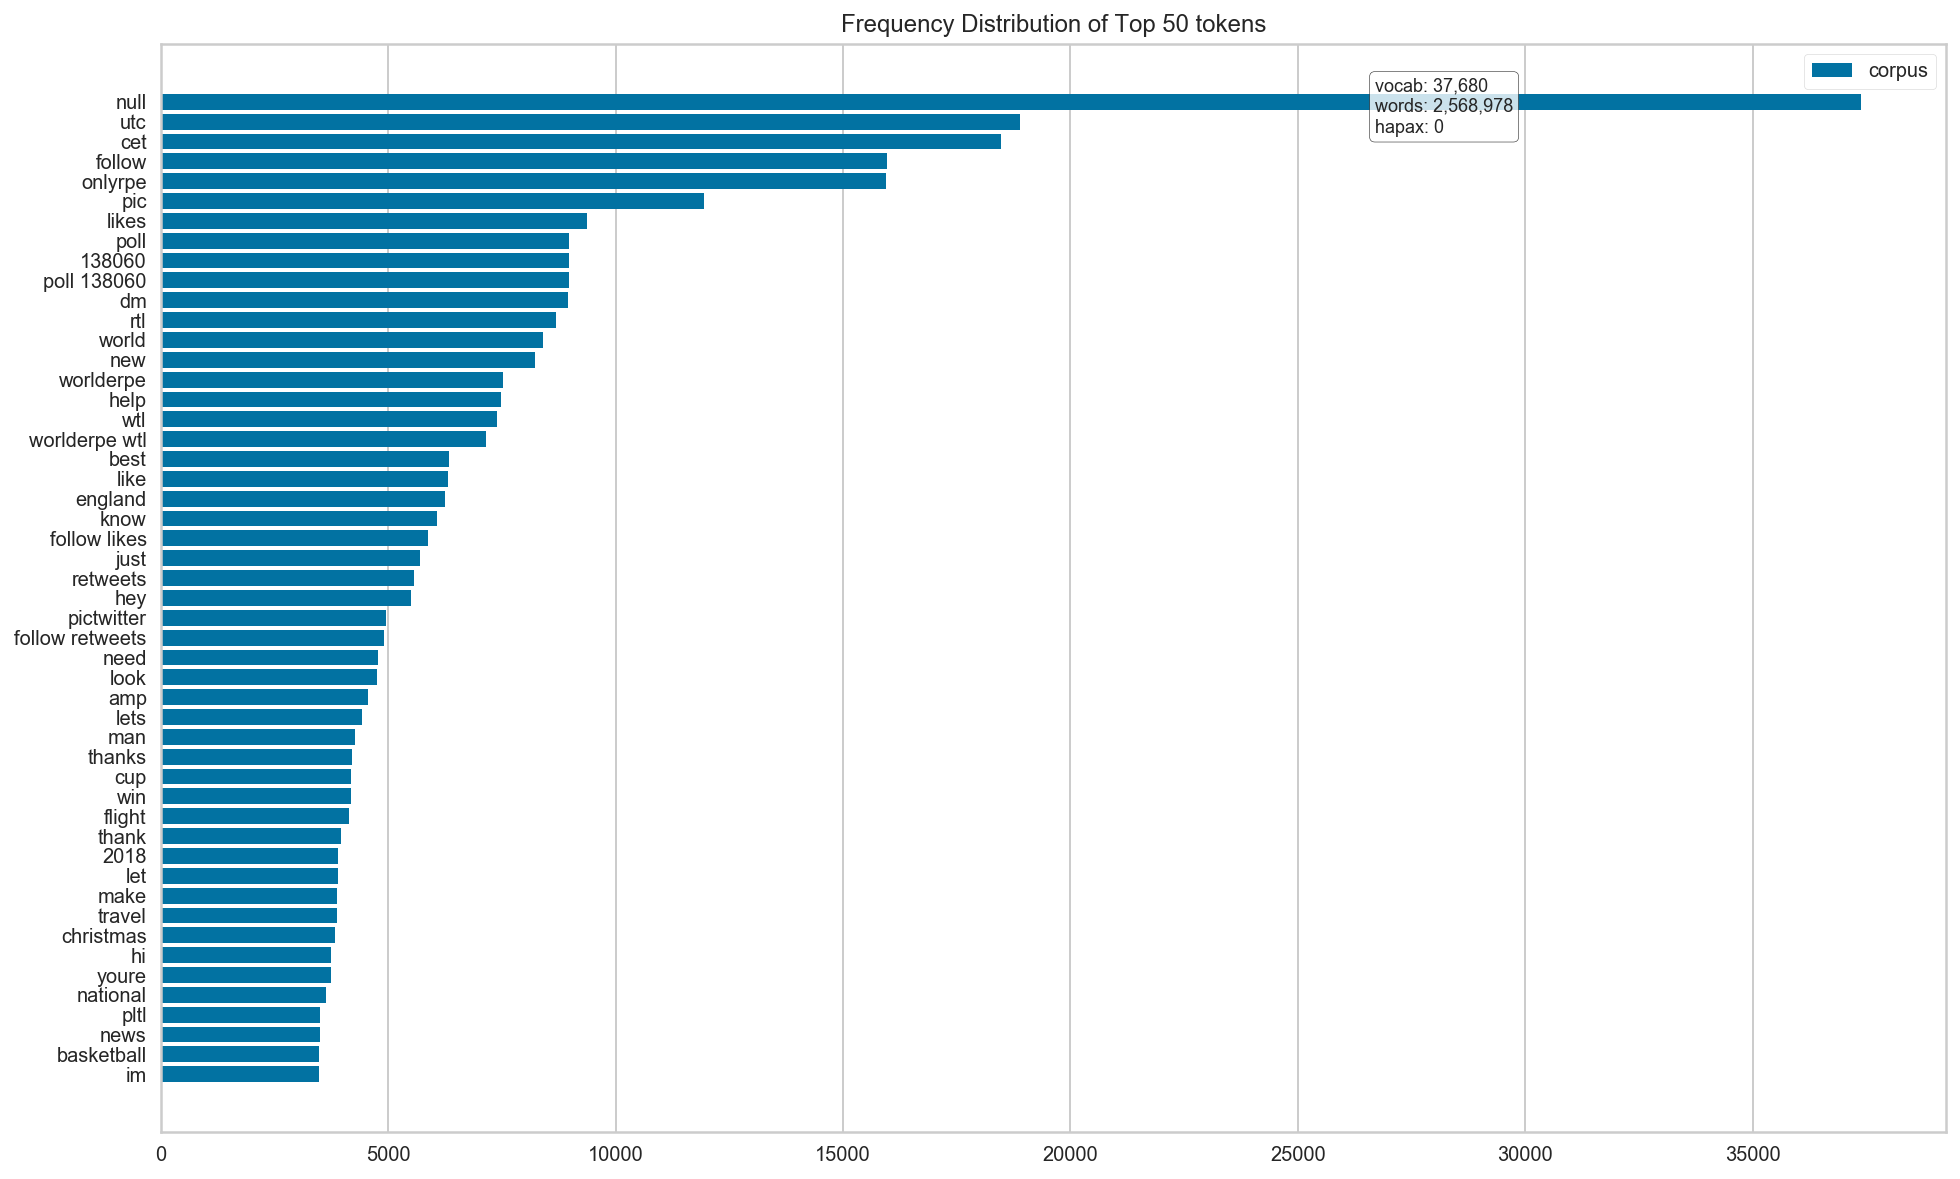

In [15]:
vect = CountVectorizer(
    tokenizer=lambda x: x.split(), stop_words="english", min_df=10, ngram_range=(1, 2)
)
docs = vect.fit_transform(raw_eng_no_rt["clean_tweet_text"].dropna())
features = vect.get_feature_names()

plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features)
visualiser.fit(docs)
visualiser.poof()
plt.show()

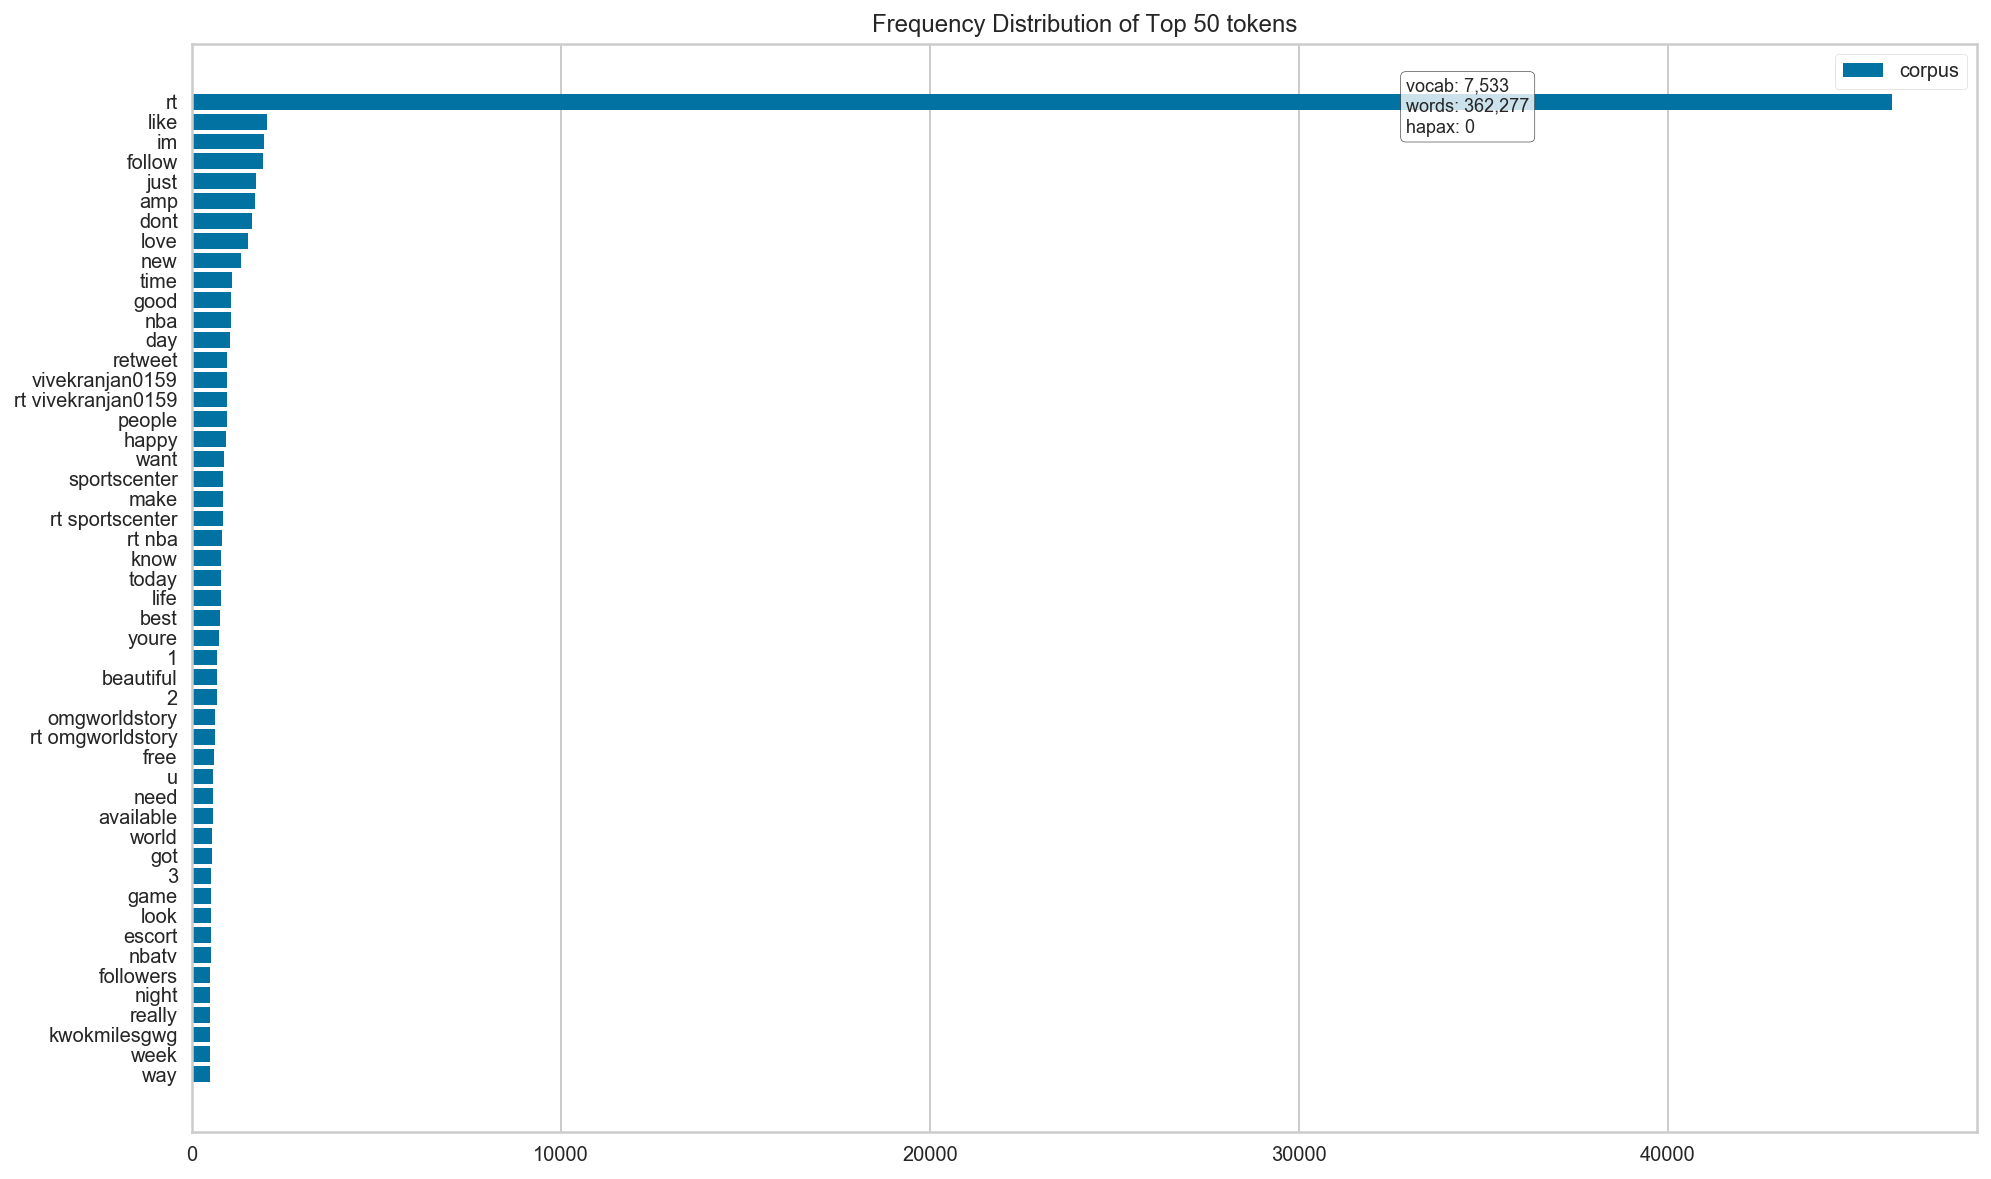

In [16]:
vect = CountVectorizer(
    tokenizer=lambda x: x.split(), stop_words="english", min_df=10, ngram_range=(1, 2)
)
docs = vect.fit_transform(raw_eng_rt["clean_tweet_text"].dropna())
features = vect.get_feature_names()

plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features)
visualiser.fit(docs)
visualiser.poof()
plt.show()

# QUICK TAKE: 
A glance at both charts immediately highlight the amount of noise in the tweets. The most frequently used terms, whether in the set with or without retweets, have nothing to do with the protests in Hong Kong.

Uncomment the cell below for a fuller sample of the irrelevant tweets:
- Football: "Italy move above England in Fifa rankings despite World Cup miss https://t.co/f03oL7j3Qd"
- Porn: "RT @AlyssaaMarie_5: 💰DM Me For Meetups &amp; Nudes. Cashapp &amp; Paypal only no exceptions. No tricks, scams, or niggas left behind☺️💦#porn #horny…"
- Tennis: ""Wimbledon 'will not be the same' without Novotna - Duchess of Kent https://t.co/Gfv3ymJj11","
- NBA: "RT @NBATV: Michael Jordan's '90-91 MVP season was one for the history books! 🏆🐐\n\n#MVPMondays https://t.co/8KZodvFyP1"

In [17]:
# raw_eng_rt[raw_eng_rt['clean_tweet_text'].str.contains('nba')].sample(10).values
# raw_eng_no_rt[raw_eng_no_rt['clean_tweet_text'].str.contains('wimbledon')].sample().values
# raw_eng_rt[raw_eng_rt['clean_tweet_text'].str.contains('porn')].sample(10).values
# raw_eng_no_rt[raw_eng_no_rt['clean_tweet_text'].str.contains('world cup')].sample(10).values

# 3. DIGGING THROUGH LAYER#2 - NARROWING DOWN TO KEY TERMS
I experimented with various ways to make this exercise more efficient, and eventually settled on the most straightforward approach - filtering for the most obvious keywords of interest, instead of trying to build a long list of words to filter out.

I picked "hong kong/hk", "police", "china", and "interference" as the key words. Pretty self-explanatory choices here, if you've been following the news on the protests.

In [18]:
# Filtering and then concating a new subset of English tweets with 5 selected key terms
no_rt1 = raw_eng_no_rt[raw_eng_no_rt['clean_tweet_text'].str.contains("hong kong")].copy()
no_rt2 = raw_eng_no_rt[raw_eng_no_rt['clean_tweet_text'].str.contains("hk")].copy()
no_rt3 = raw_eng_no_rt[raw_eng_no_rt['clean_tweet_text'].str.contains("police")].copy()
no_rt4 = raw_eng_no_rt[raw_eng_no_rt['clean_tweet_text'].str.contains("interference")].copy()
no_rt5 = raw_eng_no_rt[raw_eng_no_rt['clean_tweet_text'].str.contains("china")].copy()

hk_eng_no_rt = pd.concat([no_rt1, no_rt2, no_rt3, no_rt4, no_rt5])

In [19]:
# Filtering and then concating a new subset of English retweets (RTs) with 5 selected key terms
rt1 = raw_eng_rt[raw_eng_rt['clean_tweet_text'].str.contains("hong kong")].copy()
rt2 = raw_eng_rt[raw_eng_rt['clean_tweet_text'].str.contains("hk")].copy()
rt3 = raw_eng_rt[raw_eng_rt['clean_tweet_text'].str.contains("police")].copy()
rt4 = raw_eng_rt[raw_eng_rt['clean_tweet_text'].str.contains("protest")].copy()
rt5 = raw_eng_rt[raw_eng_rt['clean_tweet_text'].str.contains("china")].copy()

hk_eng_rt = pd.concat([rt1, rt2, rt3, rt4, rt5])

In [20]:
hk_eng_no_rt.shape, hk_eng_rt.shape

((1489, 21), (1202, 21))

# NOTE:
These 2 subsets are far smaller compared to our first set of filtered English tweets, which consisted of 44,890 retweets and 291509 "original" tweets. The new subsets are even smaller when compared to the original, overall set of 3.6 million tweets.

This raises the question of how Twitter goes about choosing what to release to the public, and how these state troll accounts are uncovered on their platform. While the social media giants have been more public in exposing these state disinformation campaigns, little is still known about the processes and benchmarks they use to uncover the trolls.

Next, let's have a quick look at the key characteristics of these smaller subsets.

## 3.1 SIFTING THROUGH "ORIGINAL" ENGLISH TROLL TWEETS 
By this I mean the non-retweets

In [21]:
# There are 99 unique users in this subset
hk_eng_no_rt['user_screen_name'].nunique()

99

In [22]:
# ID-ing the top accounts and checking on tweets from these troll accounts
hk_eng_no_rt['user_screen_name'].value_counts().head(41)

klausv02                                        118
ctcc507                                          82
honyBurchr                                       72
IFL1E0m0SRX2cdOtuLFV7xKtnBgxagKzNgkuGFvNtvs=     57
mxZ1auZT3Uk2tNtsT3jk42gR5BPYOtSRPOQx1kNzo=       45
cO2F1tY5msaogf69z7RBOcQvMtATHHJNqurj1DkdU=       41
2qbayrORywId+83MjVmEROG+KjmOyTuzpp6g0RkYb8=      41
rjNejV4I6ASDG9aR8YqvQLHuMQ3Vbpvrzu2k2r57D2o=     41
6fxdBS7M0NZMGtUtKfOWYi4ekC5JErjXGP+gQN4ais=      40
Kmto+XqJ6hcowk0GvAGVEasNxHUW11beLphANrm3uhE=     40
NMN0qc8bdhLJMAPUZDuL1IIzICVeebM3ezzR+uMa7g=      40
iHIh+RILI5VBKy+GW9f9xnlRG+bgHirep8asHfMy1Q=      38
4Ku2lWnXpk4lnFHETcAu7lnSjBMvIC7PY9q551lgVuA=     37
W8p+9rcodeTsTUcwjGDN0fflucRtDy5fcQiTi1P+OGU=     37
ovmVhOG2yR6M4t8K5K2nNOOehTynAc9ajYqSeGn7Lh0=     35
0jFZp2sQdCYj8hUveyN4Llxe2UvFbQgTqxaymZihMM0=     35
zTe7dg9+T1p0zDFBdE4Dos7nDO2e8TNVxGlNDDMPUY=      35
SBuO1wiKtQZBsS+hwKlTuHZwg0UlYNCtM57mzHiBZg=      35
D3ZwcCm1Q1WNkKWaakHKQ+JUEFVJlkVudsGO4RPWwzw=     35
dBKYVP1Hsg1V

### Dream News(ctcc507) and HK時政直擊(HKpoliticalnew) are by now "familiar names", having been highlighted in Twitter's press release for their tweets.
The other accounts in this subset, however, did not appear to have sent out large number of tweets targetting the HK protests. See the sample tweets below:

In [23]:
# See notebook1.0 for an earlier discussion of ctcc507's tweets targetting HK
# This account is arguably the most active in pushing English-language tweets against the HK protests
hk_eng_no_rt[hk_eng_no_rt['user_screen_name']=='ctcc507']['tweet_text'].head().values

array(['‘No doubt’ UK meddling in Hong Kong .\nOn July 1, some extremists took extremely violent actions to smash and destroy the LegCo， raised the colonial British flag inside the building. The former member of British parliament George Galloway has made his opinion on this provocation. https://t.co/JEYViSN2Hp',
       "An exhibition marking the 70th anniversary of the founding of the People's Republic of China (PRC) will open Wednesday in the Hong Kong Special Administrative Region (HKSAR), featuring some 210 invaluable treasures.",
       "Are these people who smashed the Legco crazy or taking benefits from the bad guys? It’s a complete violent behavior, we don't want you radical people in Hong Kong. Just get out of here ! https://t.co/GxglPNU82J",
       'The legislative council belongs to the people of Hong Kong . Those people with ulterior motives indicated by forces hide behind the scenes laid siege to the legislative, which is a serious insult to most of the Hong Kong people.',

In [24]:
# See notebook1.0 for an earlier discussion of HKpoliticalnew's tweets targetting HK
# This account sent far fewer original English tweets compared to ctcc507
hk_eng_no_rt[hk_eng_no_rt['user_screen_name']=='HKpoliticalnew']['tweet_text'].head().values

array(['@ahdee1004 @initiumnews This is the fact. As a Hong Kong person, I have the right to speak for Hong Kong. You are not aware of the actual situation in Hong Kong. As a media person and a Hong Kong person, I have the power to speak the truth on behalf of Hong Kong!',
       '@Mentimins Thank you for your long-term attention. We will release the real news of Hong Kong to you in time to let more friends know the truth of the matter!',
       "And as a media, @BBCWorld don't report facts in a fair way. It is clear that you are politically biased and not in line with public opinion in Hong Kong.",
       'Obviously, first there were agents on the scene to direct and disrupt Hong Kong, and then the us government came forward to accuse and sanction Hong Kong. These agents exerted pressure on China and Hong Kong government by spreading negative information about Hong Kong. #HK https://t.co/Q6dGQUUHoG',
       '@SpursOfficial @HKane Great'], dtype=object)

In [25]:
hk_eng_no_rt[hk_eng_no_rt['user_screen_name']=='emiliya_naum']['tweet_text'].values

array(['Hong Kong is a beautiful city.',
       'Hong Kong is a beautiful city, but it is not safe at all. I hope the police will severely punish the criminals.',
       'Hong Kong is a beautiful city, but it is not safe at all. I hope the police will severely punish the criminals.'],
      dtype=object)

The other accounts in this subset did not appear to have sent out tweets targetting the protest movement. Or perhaps Twitter did not include them in the public release.
Uncomment the cell below for a sample of their tweets. Mostly irrelevant stuff like:
- "BoochkinBoo Called it!"
- "sooyeon_fashion: 170206 Jessica Jung @ Incheon Airport heading to Hong Kong to attend Red Valentino @ Harbour City… https://t.co/xRIuLhVIIh"


In [26]:
# hk_eng_no_rt[hk_eng_no_rt['user_screen_name']=='klausv02']['tweet_text'].values
# hk_eng_no_rt[hk_eng_no_rt['user_screen_name']=='honyBurchr']['tweet_text'].head().values

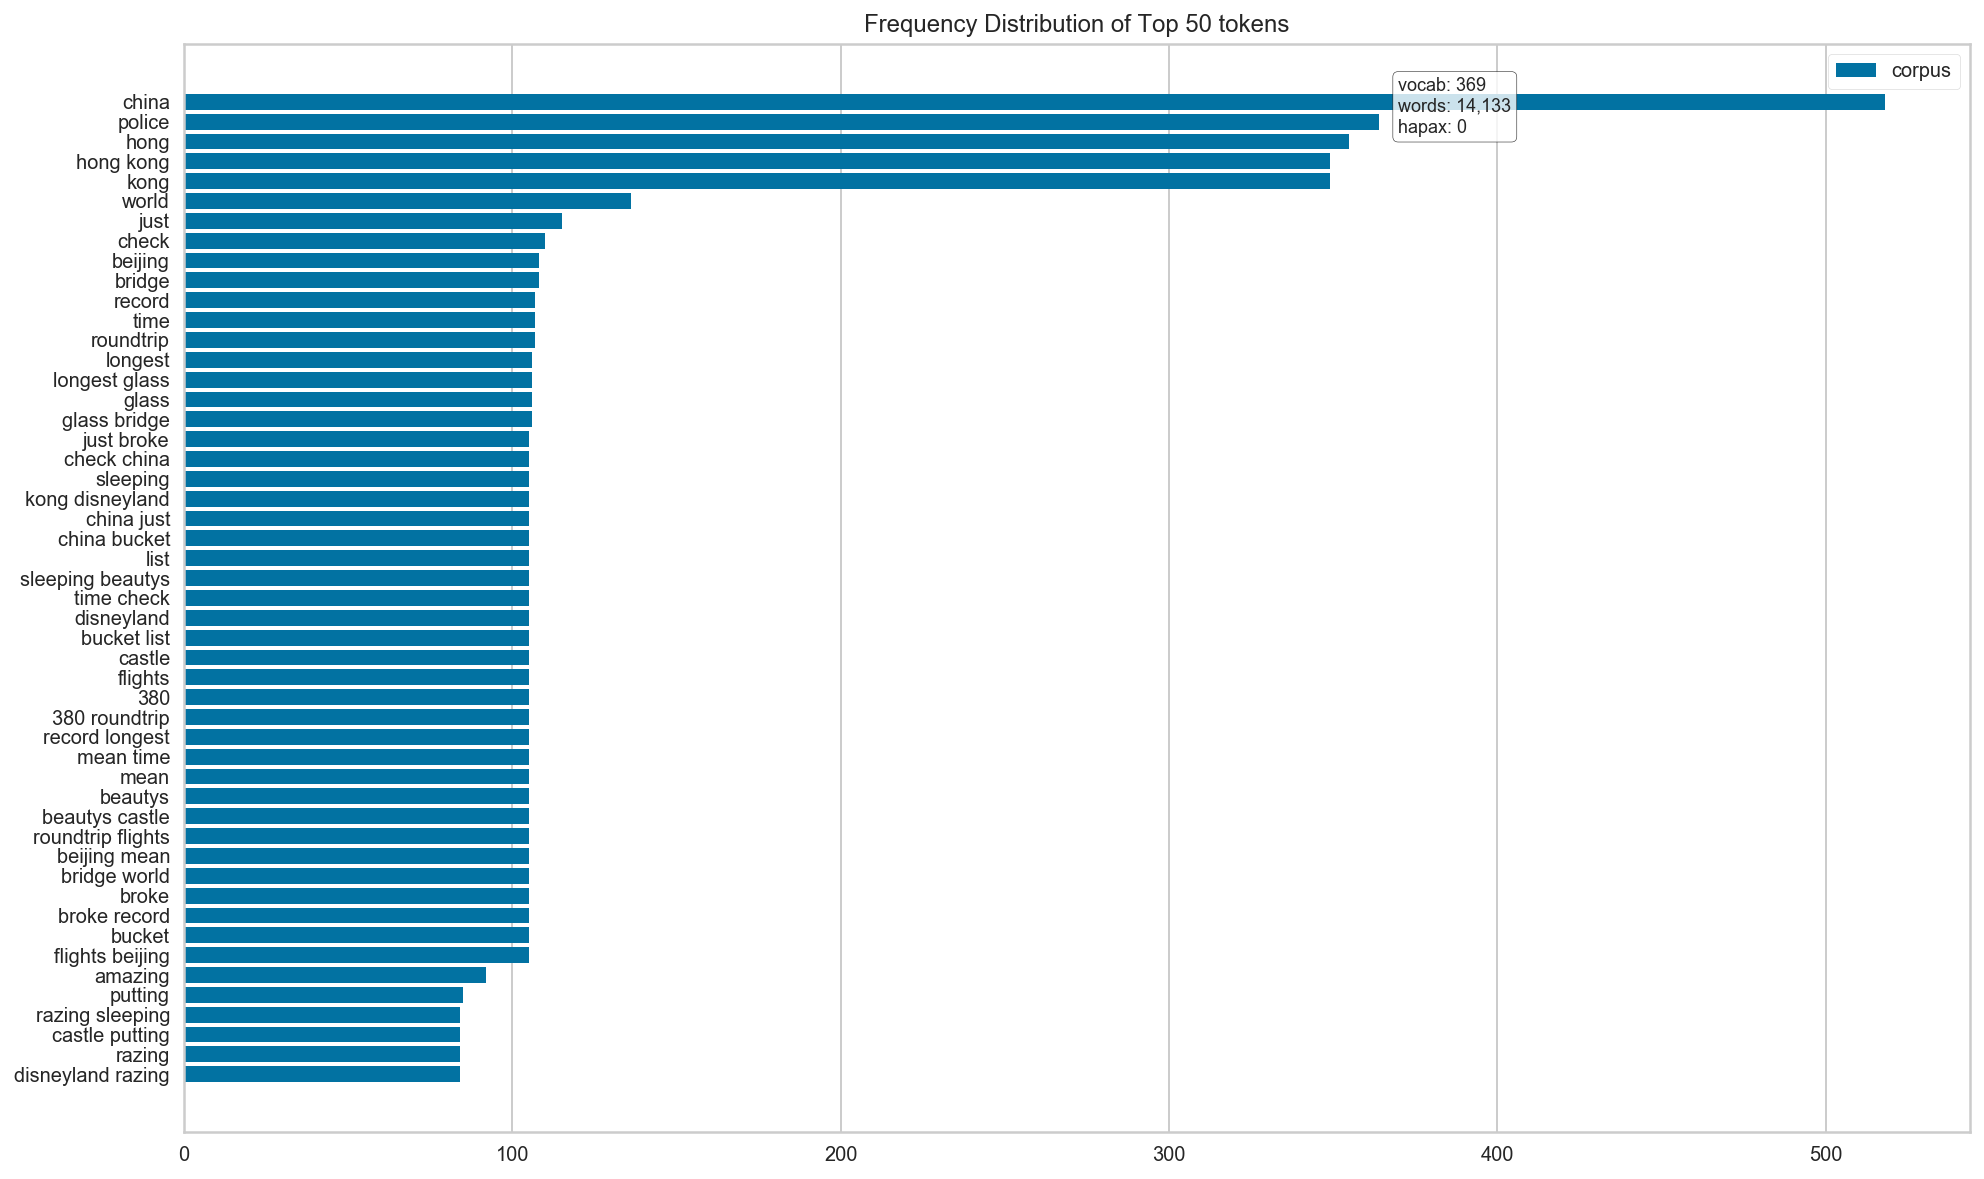

In [27]:
# Install the yellowbrick library if this chart doesn't show up for you

vect = CountVectorizer(
    tokenizer=lambda x: x.split(), stop_words="english", min_df=10, ngram_range=(1, 2)
)
docs = vect.fit_transform(hk_eng_no_rt["clean_tweet_text"].dropna())
features = vect.get_feature_names()

plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features)
visualiser.fit(docs)
visualiser.poof()
plt.show()

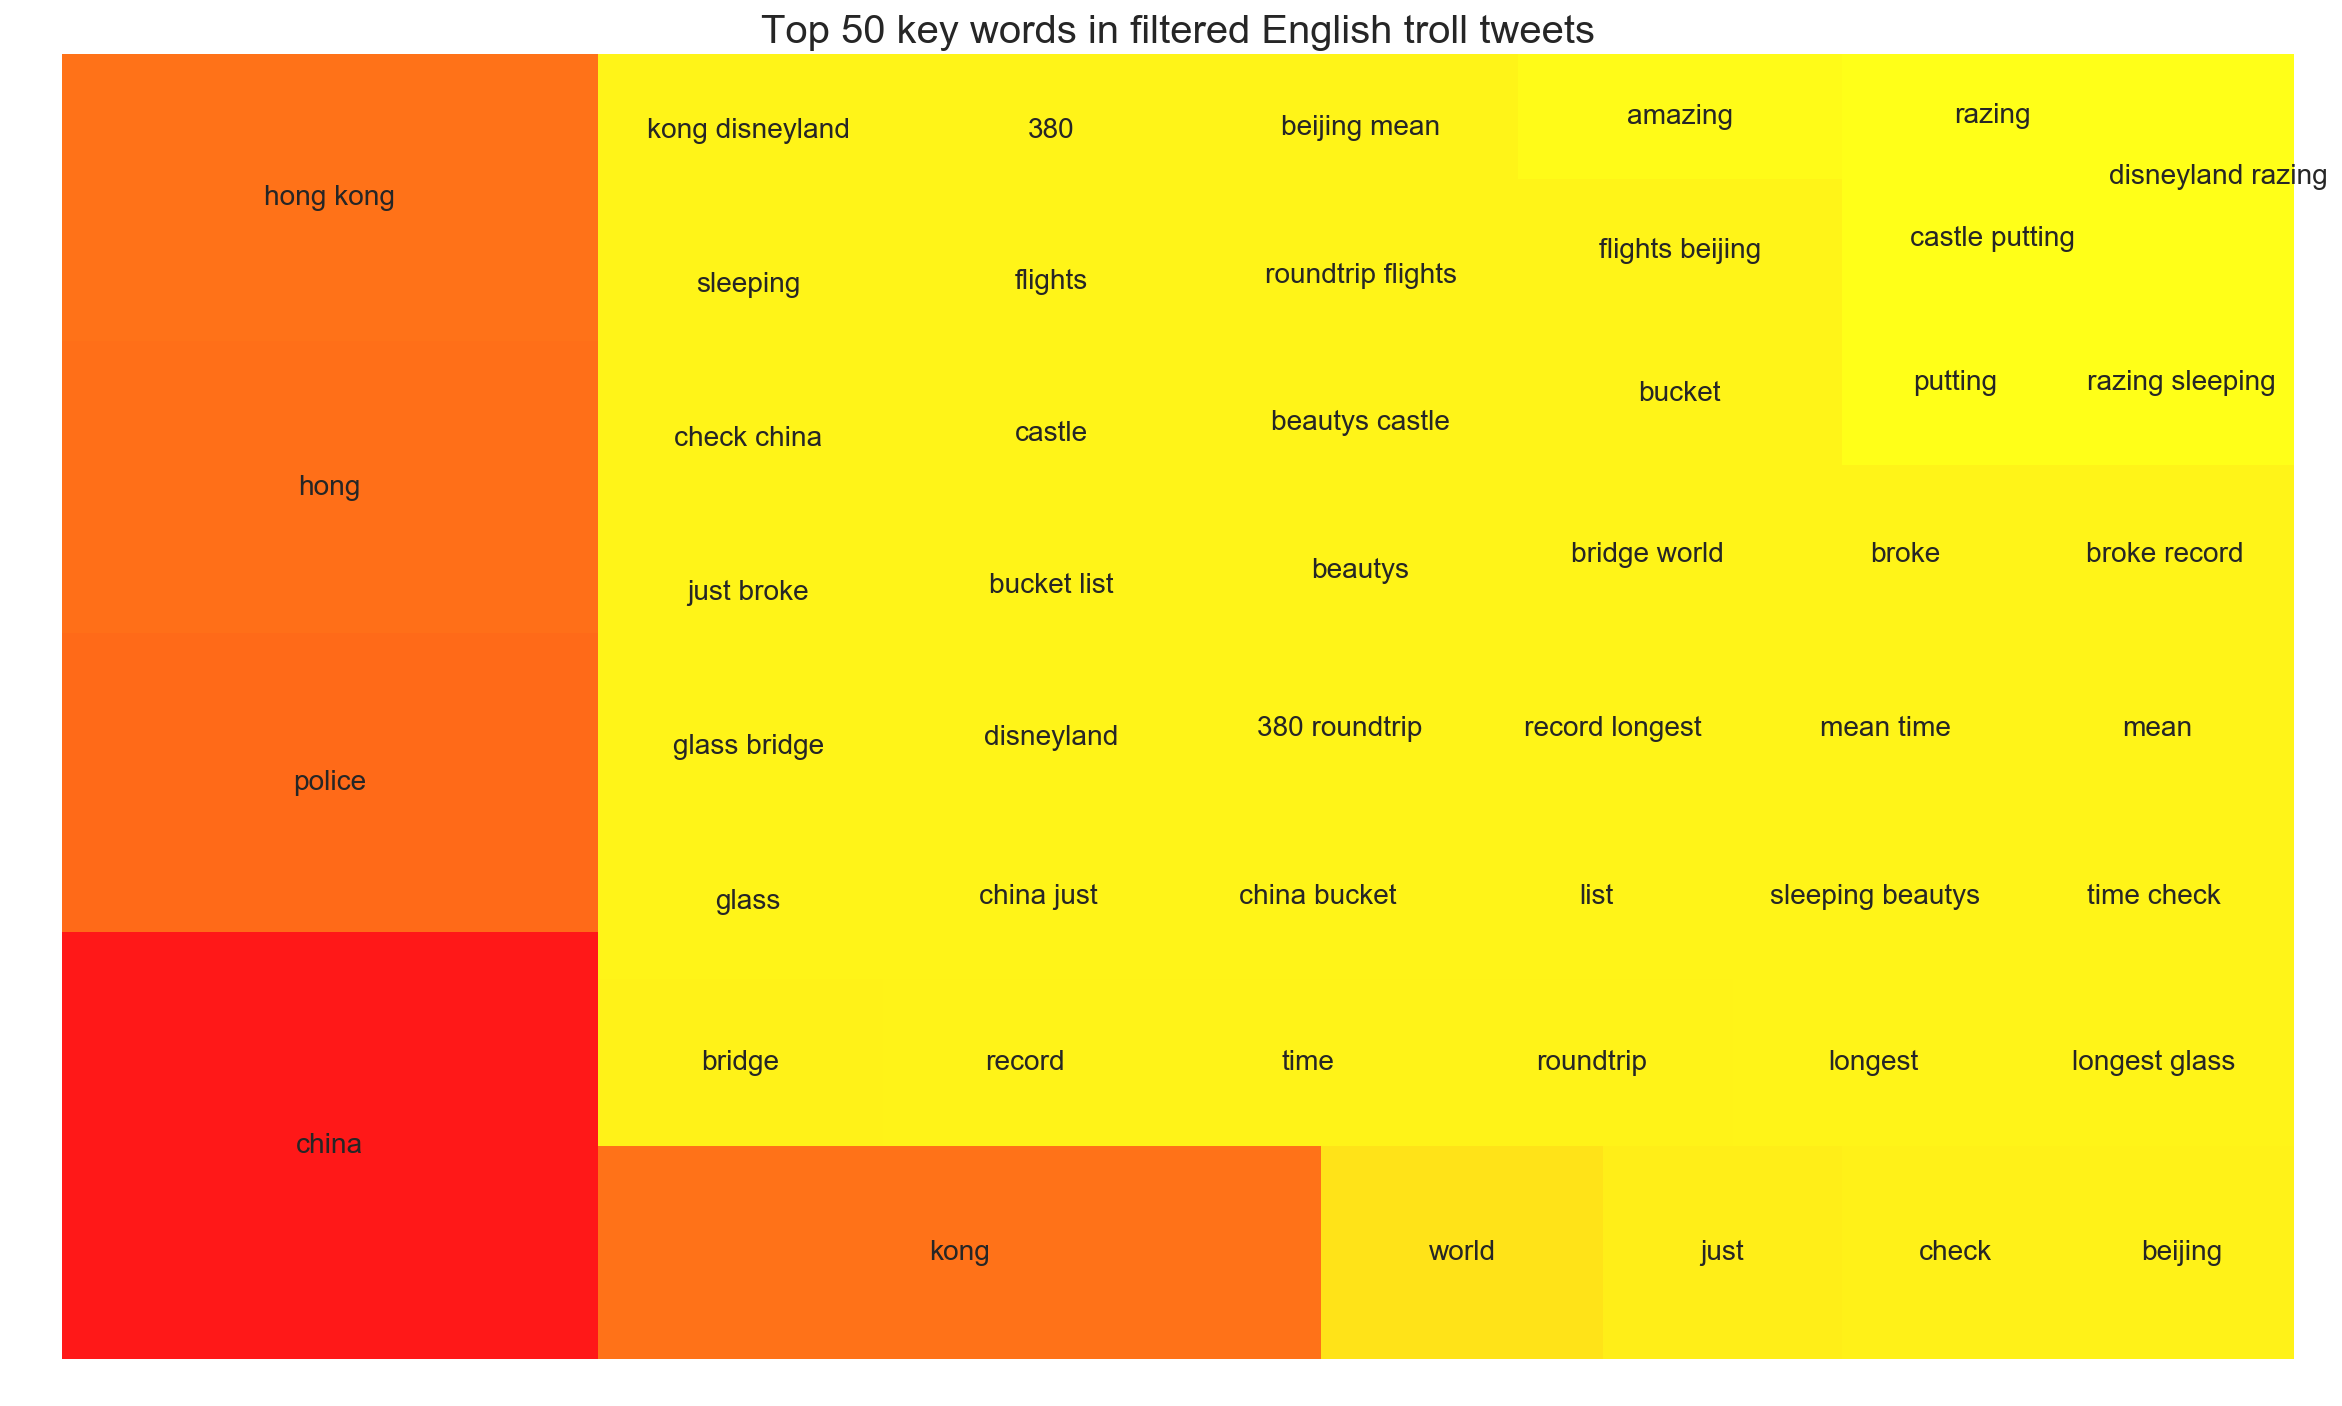

In [28]:
# Install the squarify library if this chart doesn't show up for you

key_words = (
    pd.DataFrame(docs.todense(), columns=features)
    .sum(axis=0)
    .sort_values(ascending=False)
    .head(50)
)
cmap = mpl.cm.autumn_r
mini = min(key_words)
maxi = max(key_words)
norm = mpl.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(word)) for word in key_words]

plt.figure(figsize=(20, 12))
squarify.plot(
    sizes=key_words,
    label=key_words.index,
    #alpha=0.8,
    bar_kwargs={'alpha':.9},
    color=colors,
    text_kwargs={"fontsize": 14},
)
plt.axis("off")
plt.title("Top 50 key words in filtered English troll tweets", fontsize=20)
plt.show()

# NOTE:
Even in this heavily filtered set, we are still getting a substantial amount of noise, with words like "glass bridge" and "disneyland" making it into the top 50 most frequently seen words.

Obvious key words like "China", "Hong Kong" and "police" top the frequency distribution chart and tree map. But it seems like the noise is still burying the more interesting phrases and key words.

Would things be any different in the retweets subset?

## 3.2 SIFTING THROUGH ENGLISH TROLL RETWEETS 

In [29]:
# There are 167 unique users in this subset consisting entirely of retweets
hk_eng_rt['user_screen_name'].nunique()

167

In [30]:
hk_eng_rt['user_screen_name'].value_counts().head()

xinwenshijie                                    102
cO2F1tY5msaogf69z7RBOcQvMtATHHJNqurj1DkdU=       63
BRu6Hx1IvaU02Hs69Dtt2k1LcW+UqN4L8spJ7iVVbok=     63
zTe7dg9+T1p0zDFBdE4Dos7nDO2e8TNVxGlNDDMPUY=      63
asdwyzkexa                                       56
Name: user_screen_name, dtype: int64

Again, we see some familiar names pop up: worldnewsnow/xinwenshijie and HK時政直擊(HKpoliticalnew). The retweets are something of a mixed-bag. xinwenshijie mostly rewteeted drivel from Chinese state media.

HKpoliticalnew is one of the few accounts actively retweeting tweets targetting the protest movement. This user also retweets material from another highly active English troll account - ctcc507.

In [31]:
hk_eng_rt[hk_eng_rt['user_screen_name']=='xinwenshijie']['tweet_text'].head().values

array(["RT @XHSports: China's reigning world champions Sui Wenjing/Han Cong top the pairs short program at the #NHKTrophy figure skating competitio…",
       'RT @PDChina: Toronto police Friday said they believe two Chinese students reported missing this week are the victims of a scam targeting Ch…',
       'RT @PDChina: Sit, stay, come, go and more: Police dogs train in N China’s Shanxi province https://t.co/TnpRDSttNE',
       'RT @XHNews: China daily briefing: Xi, Trump visit Forbidden City; East China police seize 20 for trading in endangered species  https://t.c…',
       'RT @PDChina: 1 Chinese tourist killed, 4 injured in a bus accident in Antalya, Turkey on Sun.; The injured to return to Beijing on Fri: Chi…'],
      dtype=object)

In [32]:
# Present in both no-RT and RT group
hk_eng_rt[hk_eng_rt['user_screen_name']=='HKpoliticalnew']['tweet_text'].head().values

array(['RT @ctcc507: The legislative council belongs to the people of Hong Kong.Those people with ulterior motives indicated by forces hide behind…',
       'RT @12fnXNOpp1j+gNAYnwAyskF+6MogejqmkKzg74ovVwc=: @ahdee1004 @initiumnews This is the fact. As a Hong Kong person, I have the right to speak for Hong Kong. You are not a…',
       'RT @hkpoliceforce: [ Note for A Public Event on 16 June】\n\nRegarding a public event to be held on Hong Kong Island tomorrow, the crowd manag…',
       'RT @trippier2: What a performance today from all the boys. Well done @HKane on the hat-trick 👏🏻👏🏻👏🏻 Time to go again v Belgium 🦁🦁🦁 https://…',
       'RT @FIFAWorldCup: 🗣️ | @England’s @HKane after winning the @Budweiser #ManoftheMatch \n#TUNENG #WorldCup https://t.co/O7J5TiuQiH'],
      dtype=object)

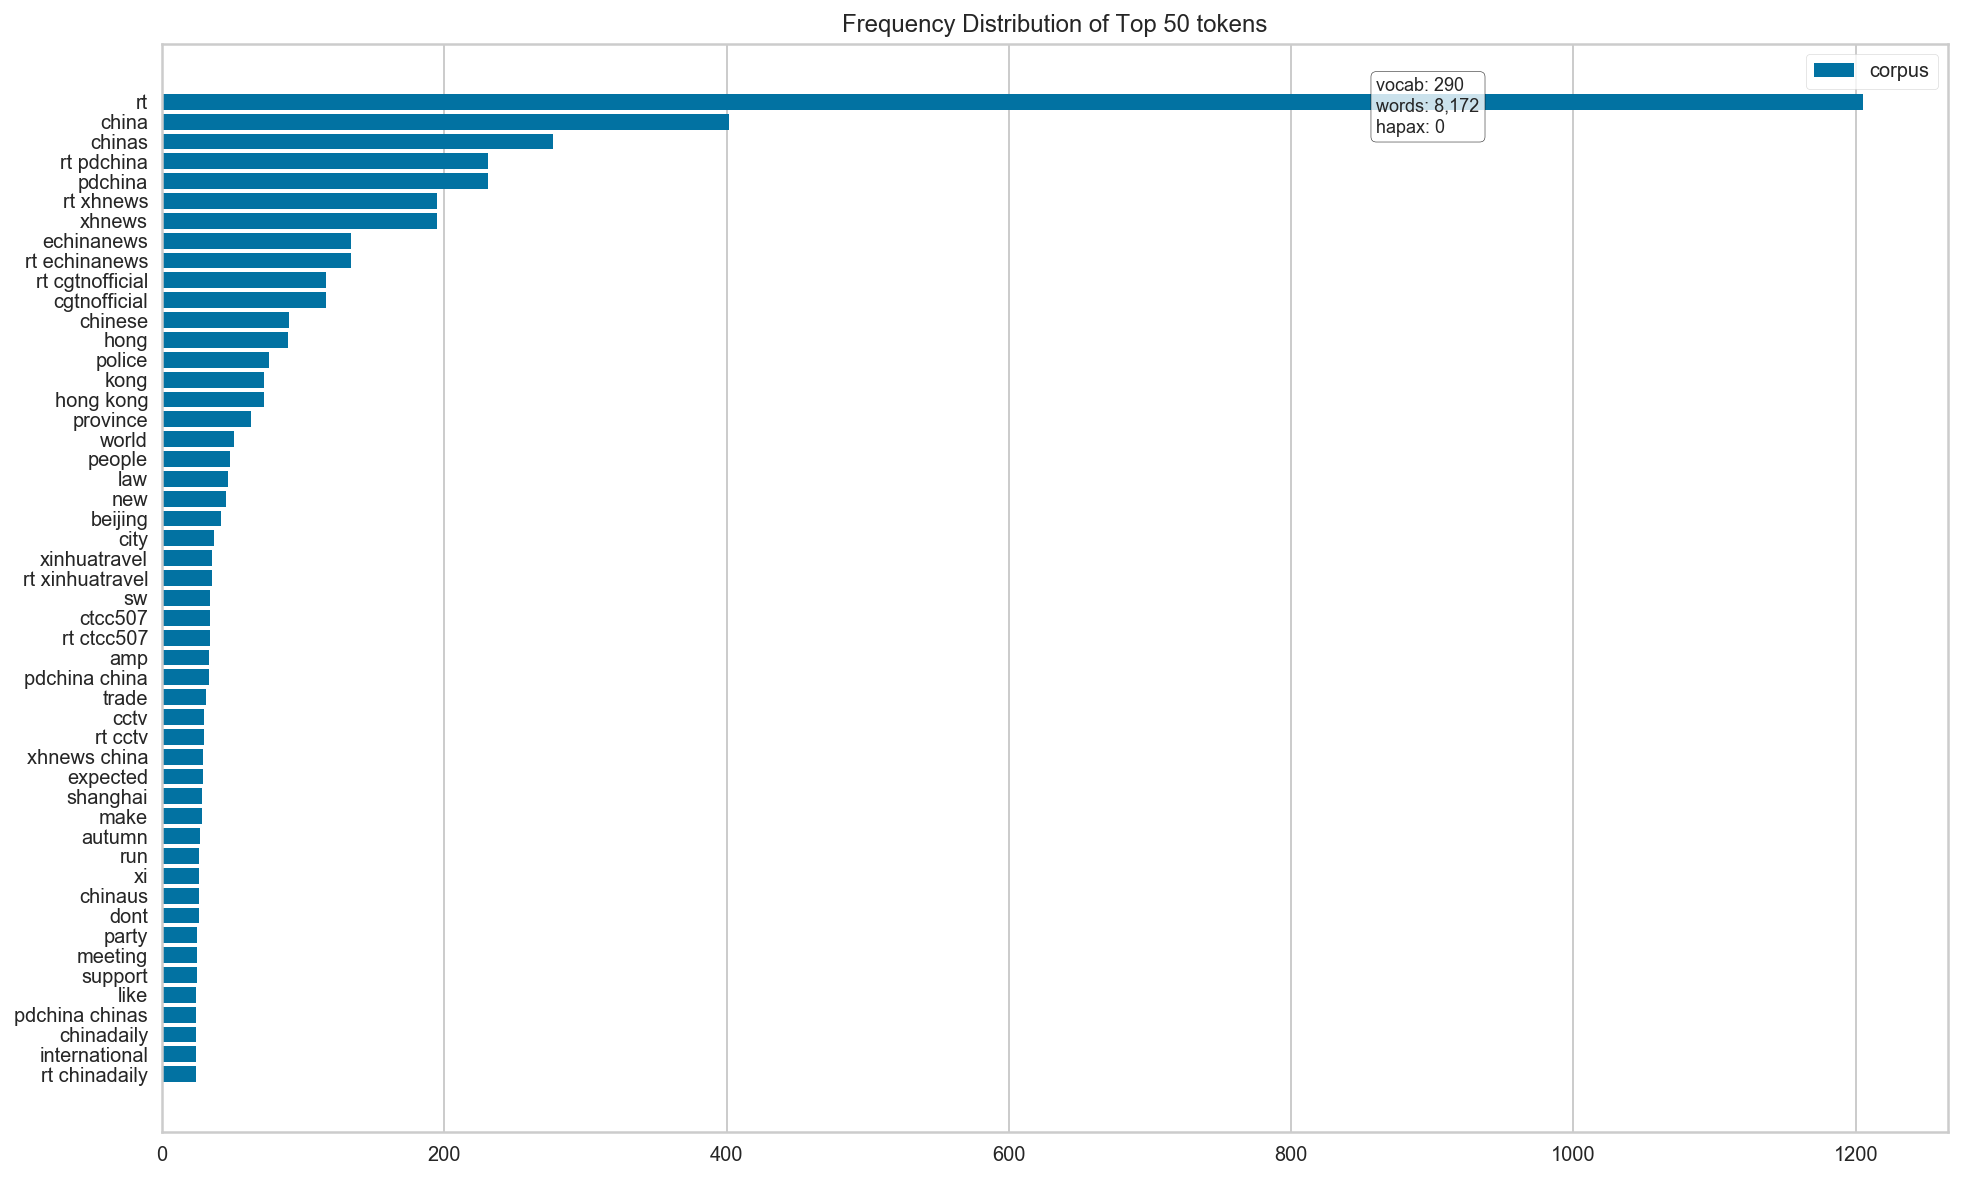

In [33]:
vect = CountVectorizer(
    tokenizer=lambda x: x.split(), stop_words="english", min_df=10, ngram_range=(1, 2)
)
docs = vect.fit_transform(hk_eng_rt["clean_tweet_text"].dropna())
features = vect.get_feature_names()

plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features)
visualiser.fit(docs)
visualiser.poof()
plt.show()

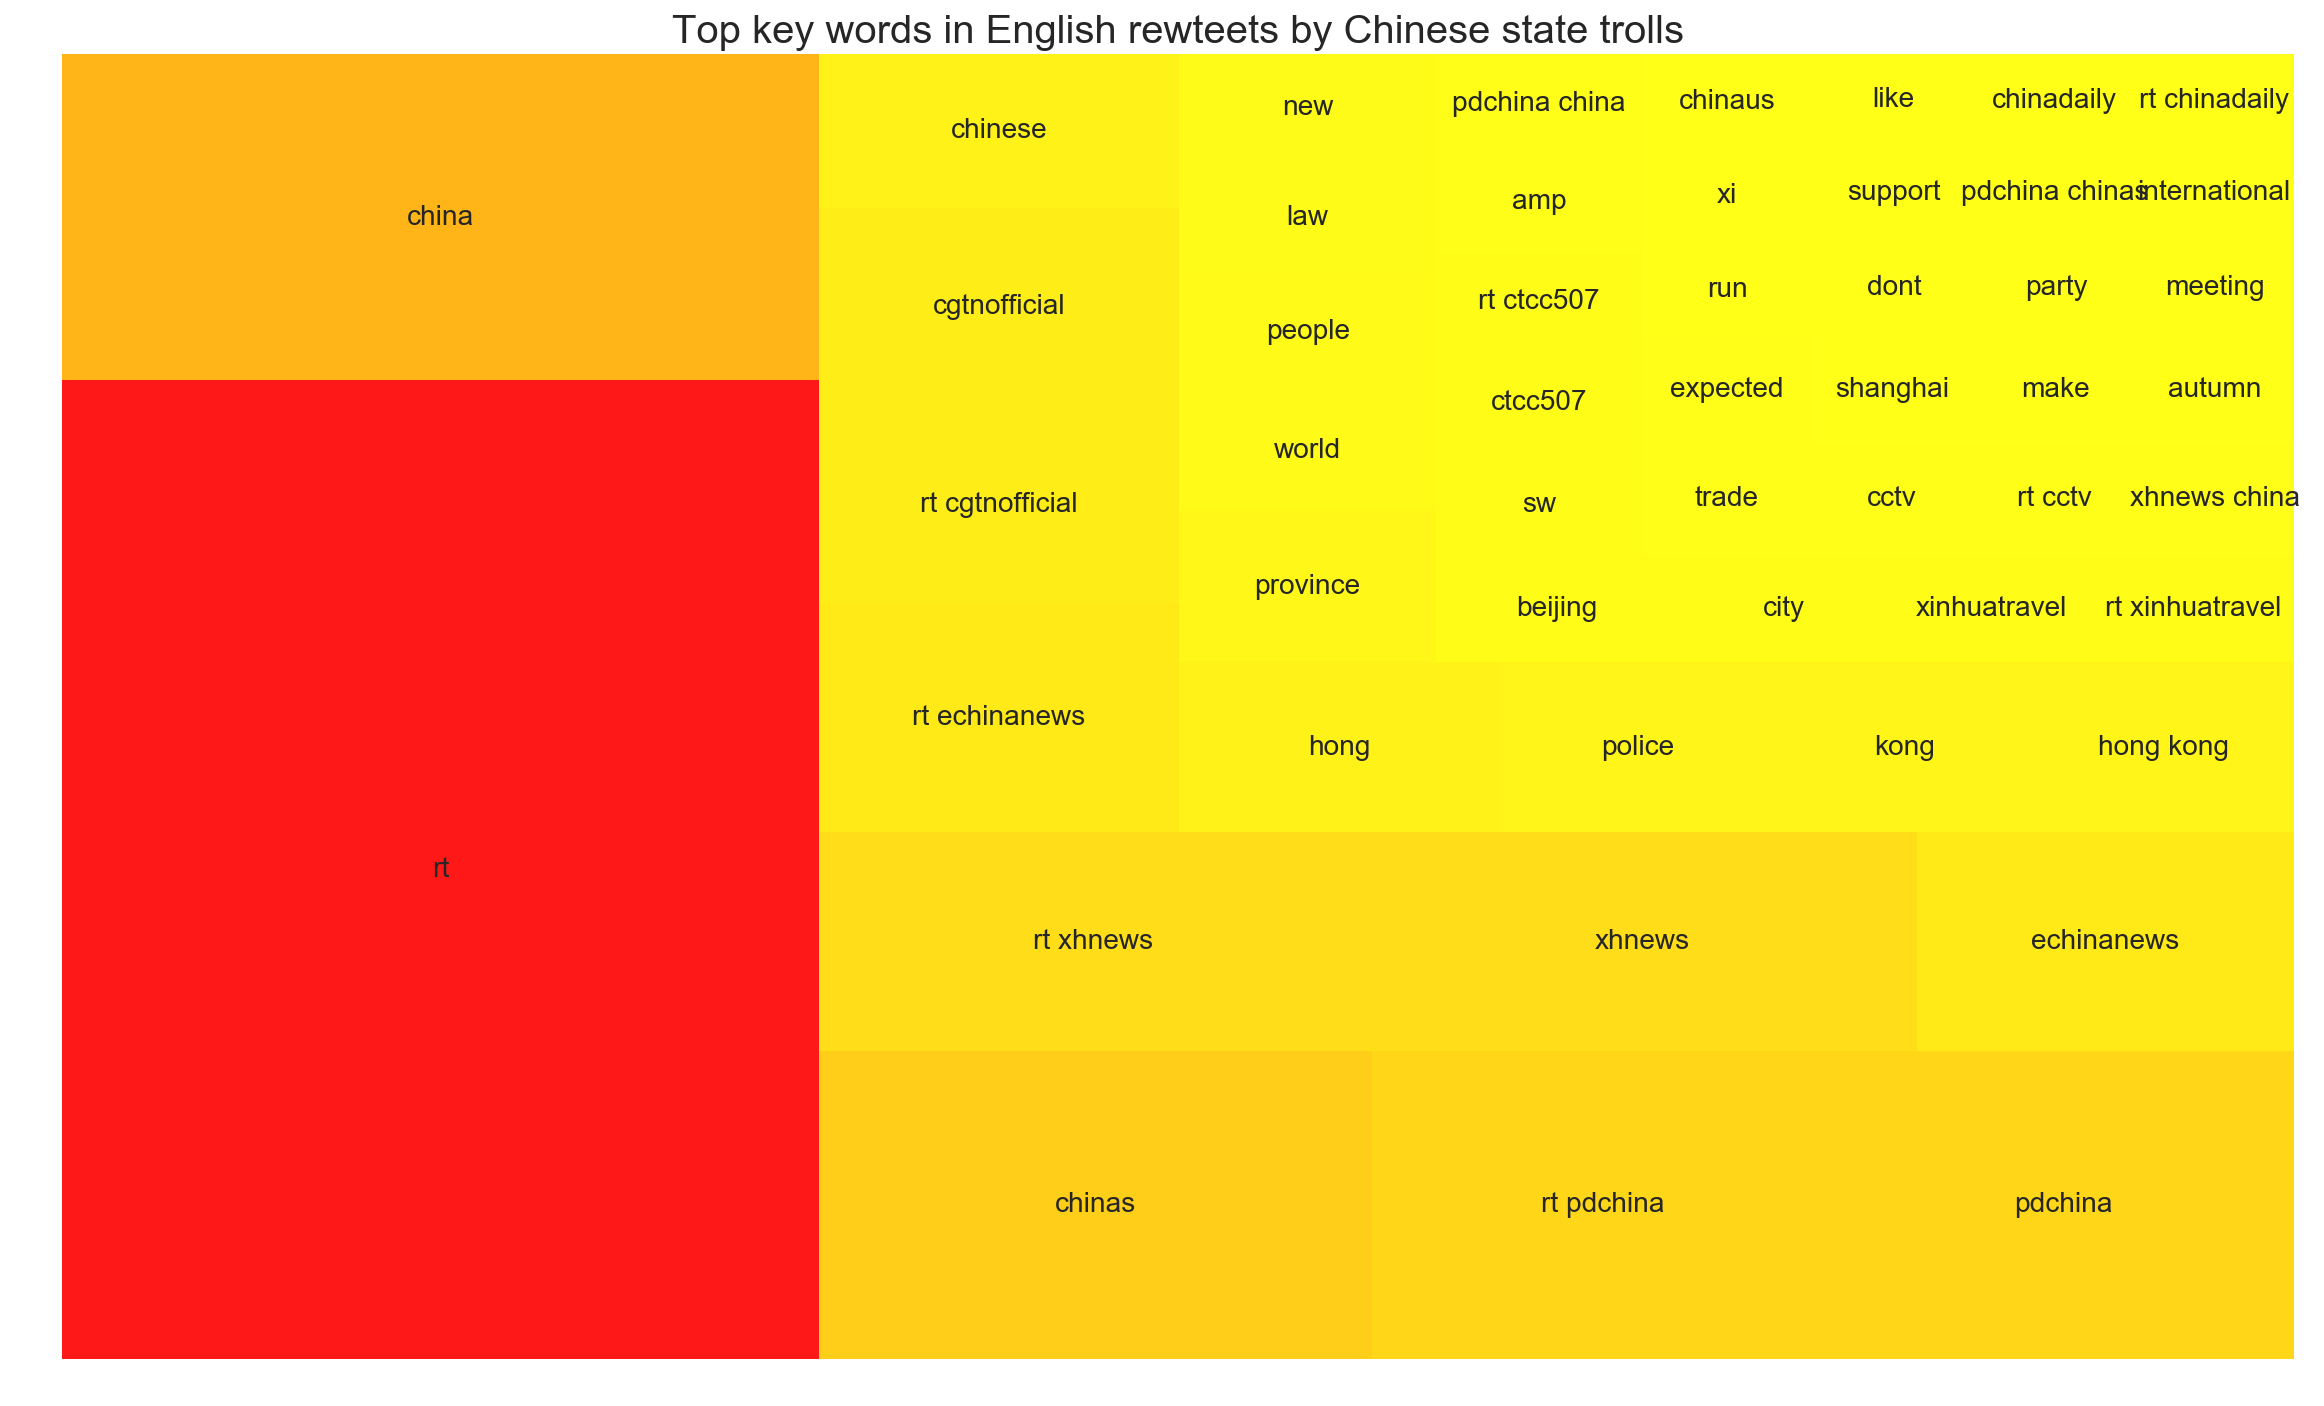

In [34]:
key_words = (
    pd.DataFrame(docs.todense(), columns=features)
    .sum(axis=0)
    .sort_values(ascending=False)
    .head(50)
)
cmap = mpl.cm.autumn_r
mini = min(key_words)
maxi = max(key_words)
norm = mpl.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(word)) for word in key_words]

plt.figure(figsize=(20, 12))
squarify.plot(
    sizes=key_words,
    label=key_words.index,
    #alpha=0.8,
    bar_kwargs={'alpha':.9},
    color=colors,
    text_kwargs={"fontsize": 14},
)
plt.axis("off")
plt.title("Top key words in English rewteets by Chinese state trolls", fontsize=20)
plt.show()

# NOTE:
The 2 charts above are of interest only in showing who the Chinese state trolls retweet a lot from - Twitter accounts of Chinese state media outlets, such as Xinhua News Agency, People's Daily and CGTN, a Chinese international news channel aimed at a global English audience. It was formerly known as CCTV-9 and CCTV News.

ctcc507, or Dream News, is also heavily retweeted by the other troll accounts in this subset.

# 4. DIGGING THROUGH LAYER#3 - THE TOP TROLLS
For the final layer, I settled on the 2 most active English accounts targetting the protest movement - 'ctcc507' and 'HKpoliticalnew'. It's no coincidence that both accounts adopted user screen names that looked like news outlets. This is straight from the [Russian 2016 campaign playbook](https://cdn2.hubspot.net/hubfs/4326998/ira-report-rebrand_FinalJ14.pdf).

In [35]:
trolls_eng = ['ctcc507', 'HKpoliticalnew']

In [36]:
top_eng_trolls = hk_eng_no_rt[hk_eng_no_rt['user_screen_name'].isin(trolls_eng)]

In [37]:
# just 92 tweets in this heavily filtered set
top_eng_trolls.shape

(92, 21)

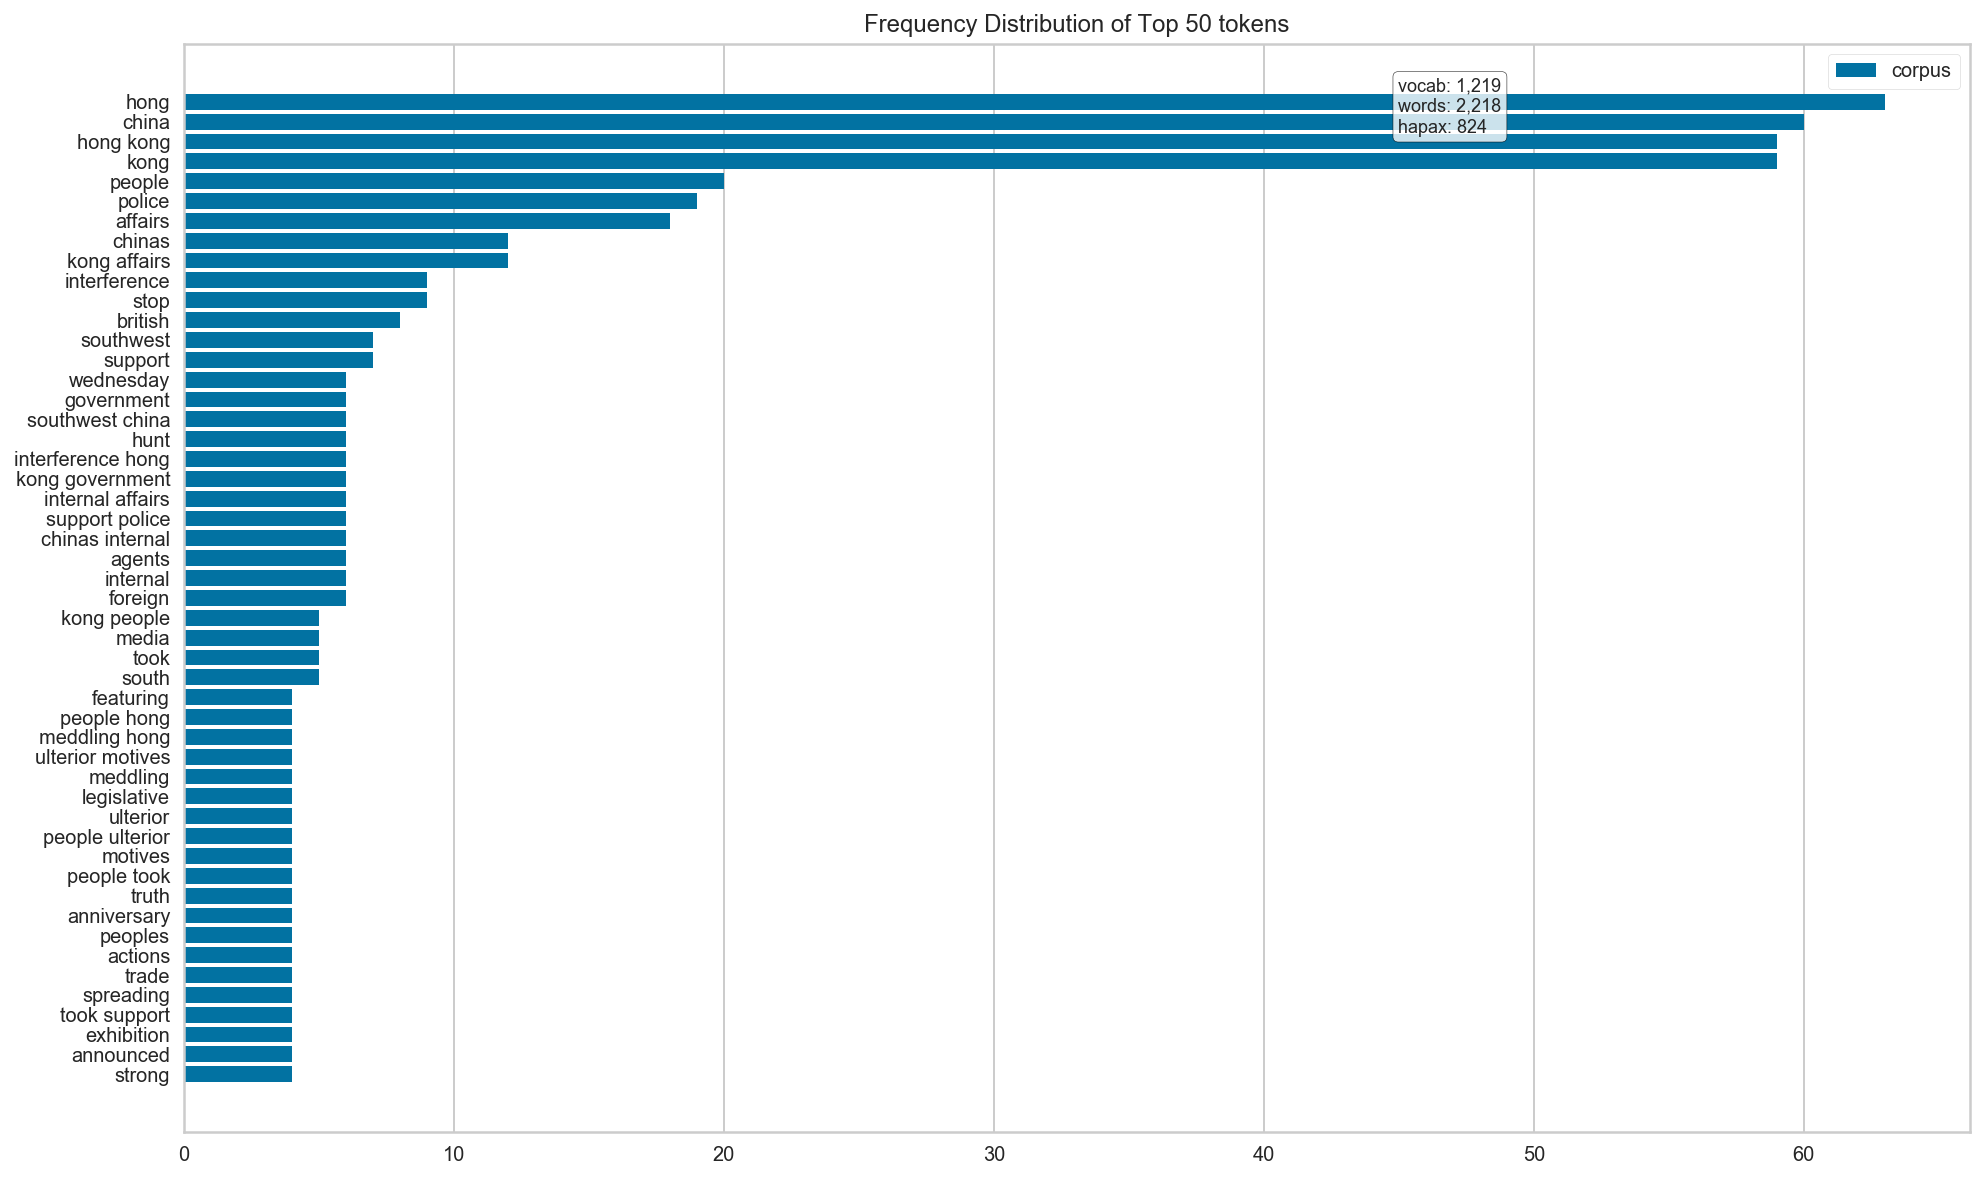

In [38]:
vect = CountVectorizer(
    tokenizer=lambda x: x.split(), stop_words="english", min_df=1, ngram_range=(1, 2)
)
docs = vect.fit_transform(top_eng_trolls["clean_tweet_text"].dropna())
features = vect.get_feature_names()

plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features)
visualiser.fit(docs)
visualiser.poof()
plt.show()

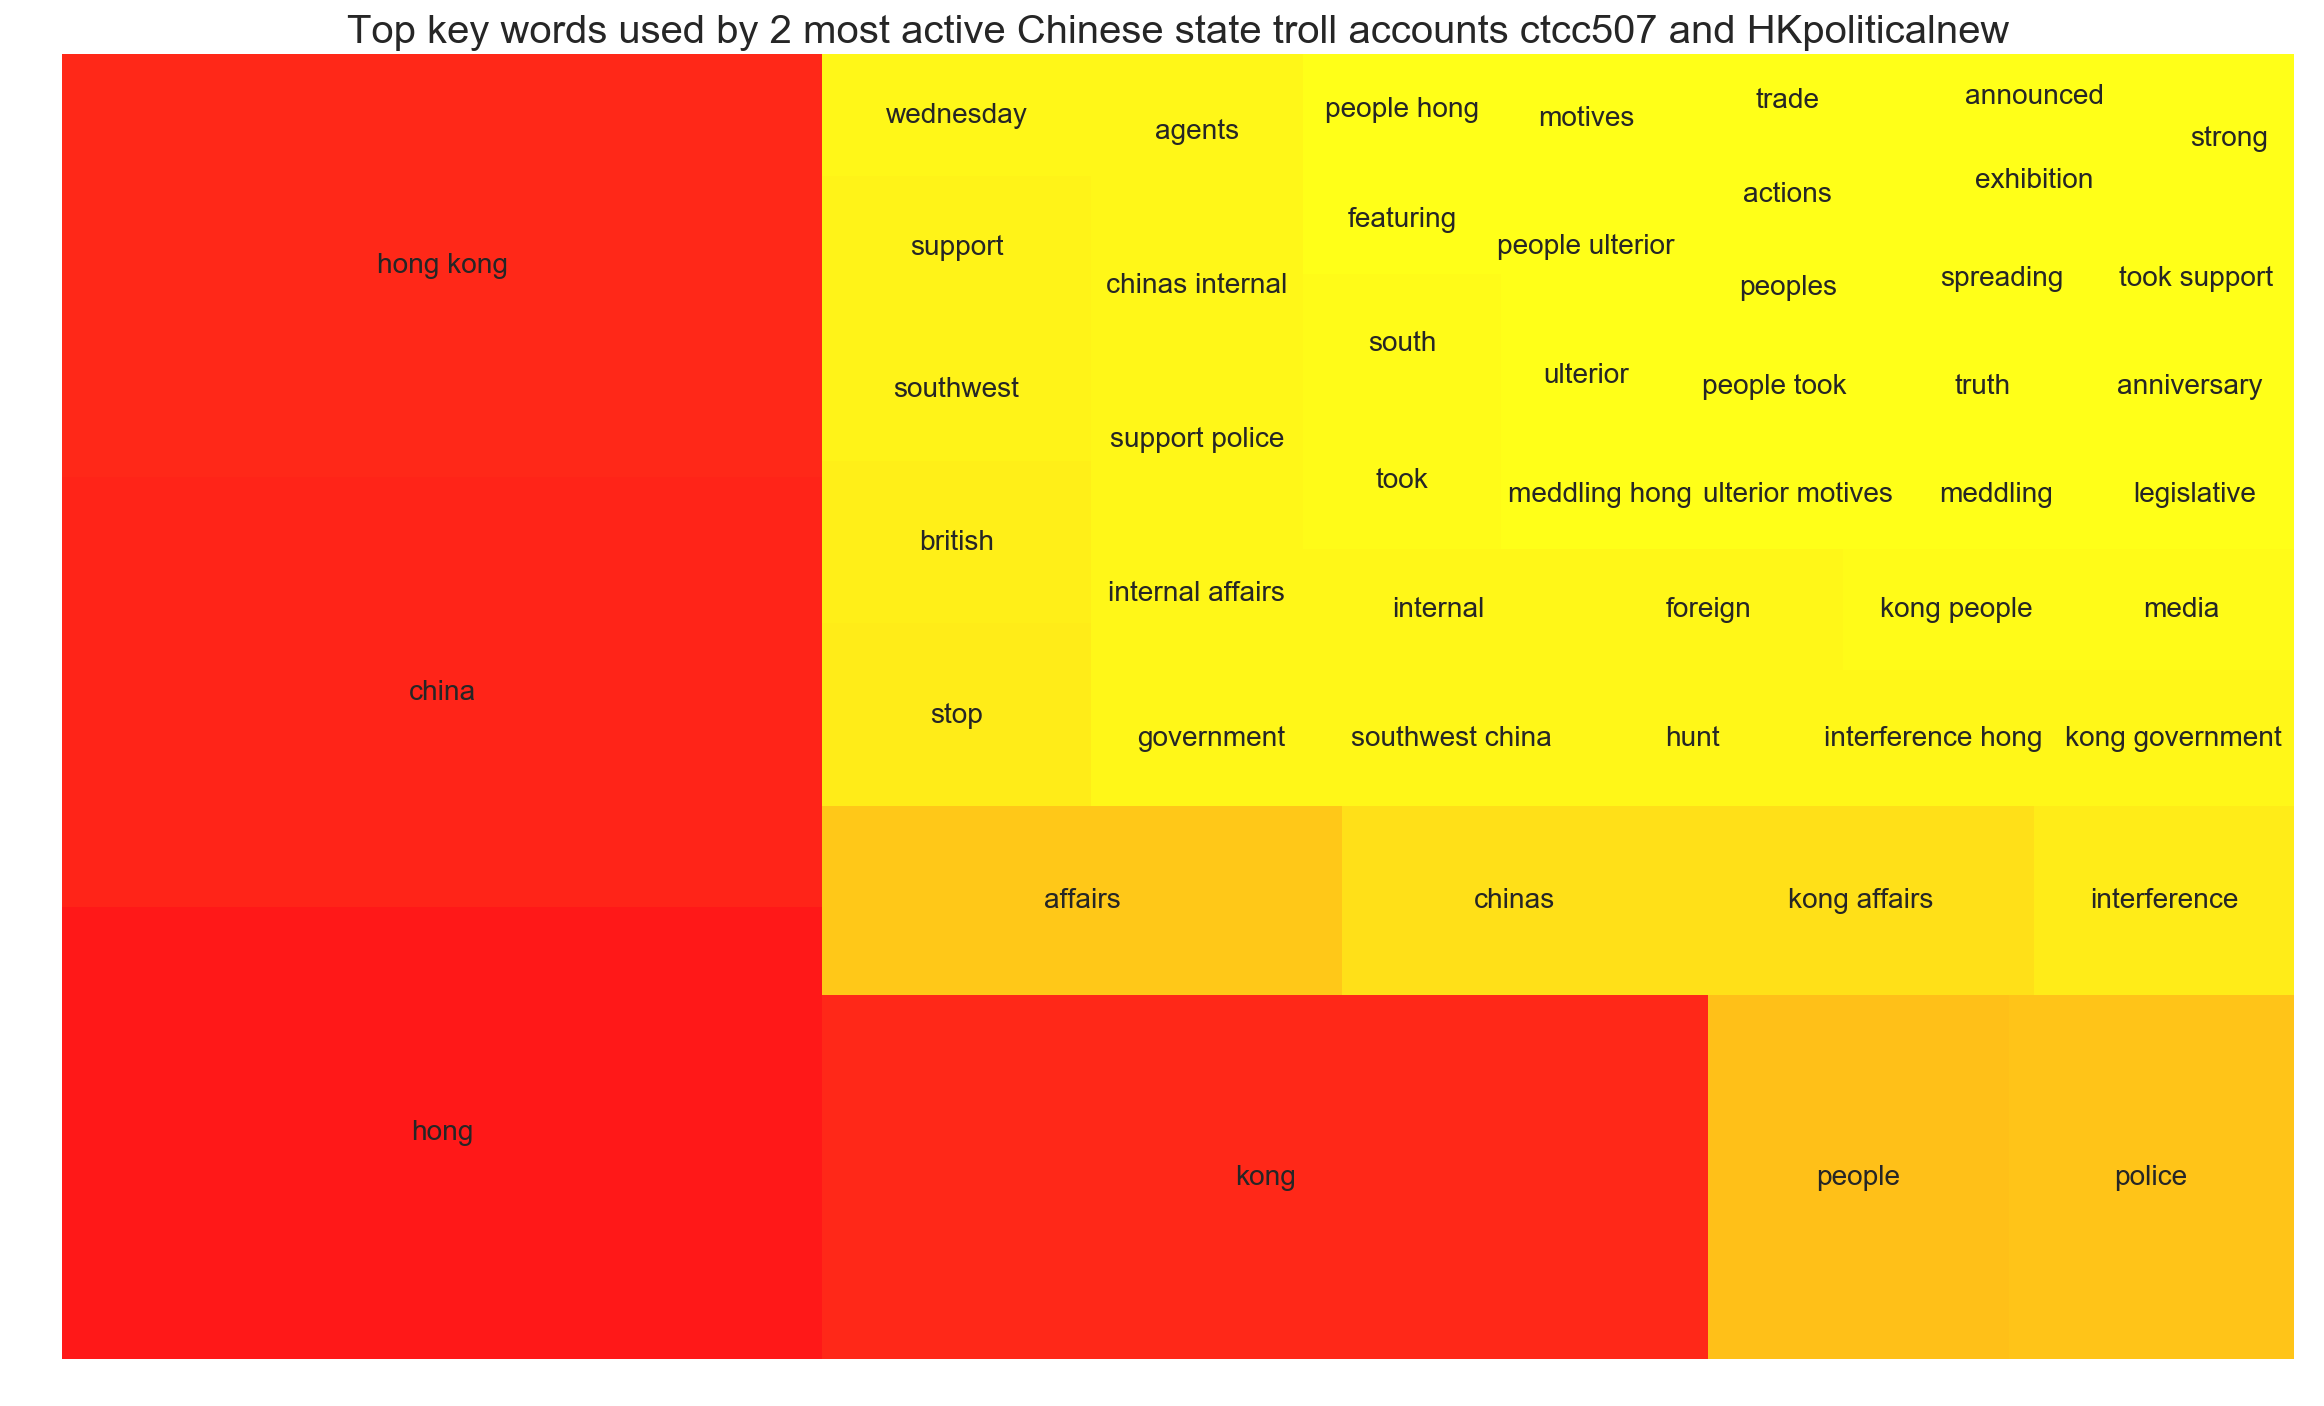

In [39]:
key_words = (
    pd.DataFrame(docs.todense(), columns=features)
    .sum(axis=0)
    .sort_values(ascending=False)
    .head(50)
)
cmap = mpl.cm.autumn_r
mini = min(key_words)
maxi = max(key_words)
norm = mpl.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(word)) for word in key_words]

plt.figure(figsize=(20, 12))
squarify.plot(
    sizes=key_words,
    label=key_words.index,
    #alpha=0.8,
    bar_kwargs={'alpha':.9},
    color=colors,
    text_kwargs={"fontsize": 14},
)
plt.axis("off")
plt.title("Top key words used by 2 most active Chinese state troll accounts ctcc507 and HKpoliticalnew", fontsize=20)
plt.show()

# NOTE: 
By focusing on the 2 most active accounts, we see more interesting phrases and key words pop up, such as "ulterior motives", "support police", and "internal affairs". These are parts of the classic stock phrases used by Chinese state media and online trolls when responding to news of this nature.

Let's have a closer look at the full tweets with these key phrases:

- @ctcc507; tweeting at 2019-07-02 12:31:00+08:00: 'The legislative council belongs to the people of Hong Kong . Those people with ulterior motives indicated by forces hide behind the scenes laid siege to the legislative, which is a serious insult to most of the Hong Kong people.'

- @HKpoliticalnew; tweeting at 2019-06-14 09:50:00+08:00: 'Obviously, first there were agents on the scene to direct and disrupt Hong Kong, and then the us government came forward to accuse and sanction Hong Kong. These agents exerted pressure on China and Hong Kong government by spreading negative information about Hong Kong. #HK https://t.co/Q6dGQUUHoG'

- @ctcc507, tweeting at 2019-06-22 21:51:00+0800: 'People with ulterior motives attempt to make waves in Hong Kong through the "color revolution", inciting student groups and Hong Kong citizens who do not know the truth, besieging the police headquarters and intending to undermine Hong Kong\'s stability. https://t.co/awxlQnMF4A',

Uncomment the cell below for a fuller look at the tweets.

The narrative being pushed by the state-sponsored trolls is as predictable as it is simplistic - that "foreign" agents are somehow behind the months-long protests which have brought millions out on the streets.

In [40]:
# top_eng_trolls[top_eng_trolls['tweet_text'].str.contains('police')].values
# top_eng_trolls[top_eng_trolls['tweet_text'].str.contains('ulterior motives')]
# top_eng_trolls[top_eng_trolls['tweet_text'].str.contains('agents')].values

In Part 2, I'll use the Scattertext tool to produce interactive visualisations of the English troll tweets